# Cookbook: Every way to make a `Molecule`

Every pathway through the OpenFF Toolkit boils down to four steps:

1. Using other tools, assemble a graph of a molecule, including all of its atoms, bonds, bond orders, formal charges, and stereochemistry[^rs]
2. Use that information to construct a [`Molecule`](openff.toolkit.topology.Molecule)
3. Combine a number of `Molecule` objects to construct a [`Topology`](openff.toolkit.topology.Topology)
4. Call [`ForceField.create_openmm_system(topology)`](openff.toolkit.typing.engines.smirnoff.ForceField.create_openmm_system) to create an OpenMM [`System`](openmm.openmm.System) (or an [`Interchange`](https://github.com/openforcefield/openff-interchange) for painless conversion to other MD formats)

So let's take a look at every way there is to construct a molecule! We'll use zwitterionic L-alanine as an example biomolecule with all the tricky bits - a stereocenter, non-zero formal charges, and bonds of different orders.

[^rs]: Note that this stereochemistry must be defined on the *graph* of the molecule. It's not good enough to just co-ordinates with the correct stereochemistry. But if you have the co-ordinates, you can try getting the stereochemistry automatically with `rdkit` or `openeye` --- If you dare!

In [1]:
# Workaround for https://github.com/conda-forge/qcfractal-feedstock/issues/43
try:
    import qcportal  # noqa
except ImportError:
    pass

import sys

ipython = get_ipython()  # noqa


def hide_traceback(
    exc_tuple=None,
    filename=None,
    tb_offset=None,
    exception_only=False,
    running_compiled_code=False,
):
    """Hide tracebacks for simpler errors."""
    etype, value, _ = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(
        etype,
        value,
        ipython.InteractiveTB.get_exception_only(etype, value),
    )


ipython.showtraceback = hide_traceback

# Hide NumPy warnings
import warnings

warnings.filterwarnings(
    "ignore",
    r"The value of the smallest subnormal for ",
)

In [2]:
from openff.toolkit import Molecule, Topology

## From SMILES

SMILES is the classic way to create a `Molecule`. SMILES is a widely-used compact textual representation of arbitrary molecules. This lets us specify an exact molecule, including stereochemistry and bond orders, very easily --- though they may not be the most human-readable format.

The [`Molecule.from_smiles()`](openff.toolkit.topology.Molecule.from_smiles) method is used to create a `Molecule` from a SMILES code.

### Implicit hydrogens SMILES

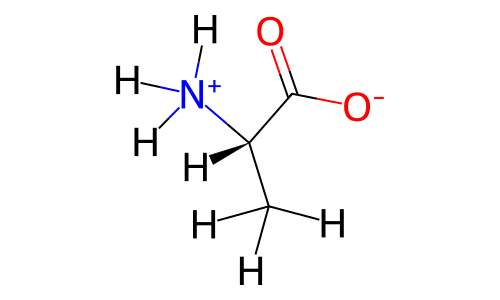

In [3]:
zw_l_alanine = Molecule.from_smiles("C[C@H]([NH3+])C(=O)[O-]")

zw_l_alanine.visualize()

### Explicit hydrogens SMILES

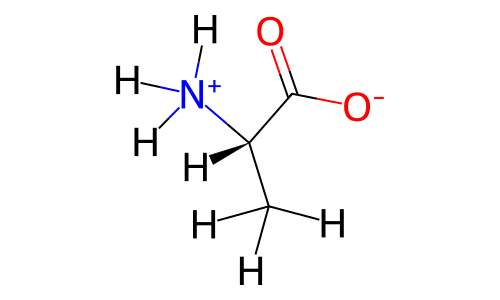

In [4]:
smiles_explicit_h = Molecule.from_smiles(
    "[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]",
    hydrogens_are_explicit=True,
)

assert zw_l_alanine.is_isomorphic_with(smiles_explicit_h)

smiles_explicit_h.visualize()

### Mapped SMILES

By default, no guarantees are made about the indexing of atoms from a SMILES string. If the indexing is important, a mapped SMILES string may be used. In this case, Hydrogens must be explicit. Note that though mapped SMILES strings must start at index 1, Python lists start at index 0.

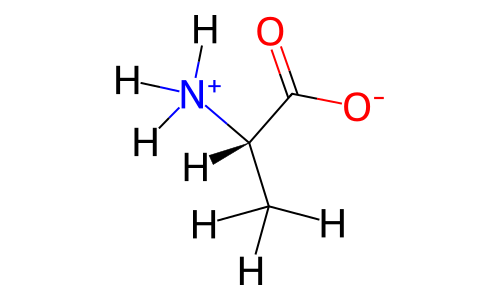

In [5]:
mapped_smiles = Molecule.from_mapped_smiles(
    "[H:10][C:2]([H:7])([H:8])[C@@:4]([H:9])([C:3](=[O:5])[O-:6])[N+:1]([H:11])([H:12])[H:13]"
)

assert zw_l_alanine.is_isomorphic_with(mapped_smiles)

# First index is the Nitrogen
assert mapped_smiles.atoms[0].atomic_number == 7

# Final indices are all H
assert all([a.atomic_number == 1 for a in mapped_smiles.atoms[6:]])

mapped_smiles.visualize()

(smiles_no_stereochemistry)=
### SMILES without stereochemistry

The Toolkit won't accept an ambiguous SMILES. This SMILES could be L- or D- alanine; rather than guess, the Toolkit throws an error:

In [6]:
from openff.toolkit.utils.exceptions import UndefinedStereochemistryError

try:
    smiles_non_isomeric = Molecule.from_smiles("CC([NH3+])C(=O)[O-]")
except UndefinedStereochemistryError as error:
    print(error)

Unable to make OFFMol from OEMol: OEMol has unspecified stereochemistry. oemol.GetTitle()=''Problematic atoms are:
Atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 0, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 9, aromatic: False, chiral: False



We can downgrade this error to a warning with the `allow_undefined_stereo` argument. This will create a molecule with undefined stereochemistry, which might lead to incorrect parametrization or surprising conformer generation. See the [FAQ](../faq.md#im-getting-stereochemistry-errors-when-loading-a-molecule-from-a-smiles-string) for more details.

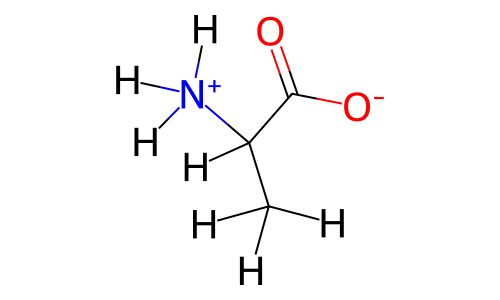

In [7]:
smiles_non_isomeric = Molecule.from_smiles(
    "CC([NH3+])C(=O)[O-]",
    allow_undefined_stereo=True,
)

assert not zw_l_alanine.is_isomorphic_with(smiles_non_isomeric)

smiles_non_isomeric.visualize()

## By hand

You can always construct a `Molecule` by building it up from individual atoms and bonds. Other methods are generally easier, but it's a useful fallback for when you need to write your own constructor for an unsupported source format.

The [`Molecule()`](openff.toolkit.topology.Molecule.__init__) constructor and the [`add_atom()`](openff.toolkit.topology.Molecule.add_atom) and [`add_bond()`](openff.toolkit.topology.Molecule.add_bond) methods are used to construct a `Molecule` by hand.

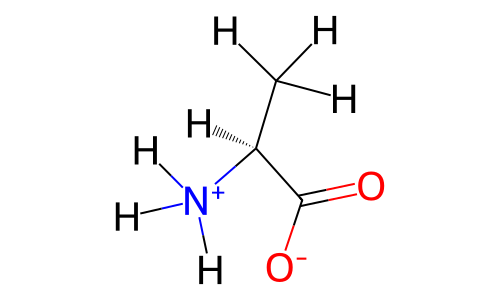

In [8]:
by_hand = Molecule()
by_hand.name = "Zwitterionic l-Alanine"

by_hand.add_atom(
    atomic_number=8,  # Atomic number 8 is Oxygen
    formal_charge=-1,  # Formal negative charge
    is_aromatic=False,  # Atom is not part of an aromatic system
    stereochemistry=None,  # Optional argument; "R" or "S" stereochemistry
    name="O-",  # Optional argument; descriptive name for the atom
)
by_hand.add_atom(6, 0, False, name="C")
by_hand.add_atom(8, 0, False, name="O")
by_hand.add_atom(6, 0, False, stereochemistry="S", name="CA")
by_hand.add_atom(1, 0, False, name="CAH")
by_hand.add_atom(6, 0, False, name="CB")
by_hand.add_atom(1, 0, False, name="HB1")
by_hand.add_atom(1, 0, False, name="HB2")
by_hand.add_atom(1, 0, False, name="HB3")
by_hand.add_atom(7, +1, False, name="N+")
by_hand.add_atom(1, 0, False, name="HN1")
by_hand.add_atom(1, 0, False, name="HN2")
by_hand.add_atom(1, 0, False, name="HN3")


by_hand.add_bond(
    atom1=0,  # First (zero-indexed) atom specified above ("O-")
    atom2=1,  # Second atom specified above ("C")
    bond_order=1,  # Single bond
    is_aromatic=False,  # Bond is not aromatic
    stereochemistry=None,  # Optional argument; "E" or "Z" stereochemistry
    fractional_bond_order=None,  # Optional argument; Wiberg (or similar) bond order
)
by_hand.add_bond(1, 2, 2, False)  # C = O
by_hand.add_bond(1, 3, 1, False)  # C - CA
by_hand.add_bond(3, 4, 1, False)  # CA - CAH
by_hand.add_bond(3, 5, 1, False)  # CA - CB
by_hand.add_bond(5, 6, 1, False)  # CB - HB1
by_hand.add_bond(5, 7, 1, False)  # CB - HB2
by_hand.add_bond(5, 8, 1, False)  # CB - HB3
by_hand.add_bond(3, 9, 1, False)  # CB - N+
by_hand.add_bond(9, 10, 1, False)  # N+ - HN1
by_hand.add_bond(9, 11, 1, False)  # N+ - HN2
by_hand.add_bond(9, 12, 1, False)  # N+ - HN3

assert zw_l_alanine.is_isomorphic_with(by_hand)

by_hand.visualize()

### From a dictionary

Rather than build up the `Molecule` one method at a time, the [`Molecule.from_dict()`](openff.toolkit.topology.Molecule.from_dict) method can construct a `Molecule` in one shot from a Python `dict` that describes the molecule in question. This allows `Molecule` objects to be written to and read from disk in any format that can be interpreted as a `dict`; this mechanism underlies the [`from_bson()`](openff.toolkit.topology.Molecule.from_bson), [`from_json()`](openff.toolkit.topology.Molecule.from_json), [`from_messagepack()`](openff.toolkit.topology.Molecule.from_messagepack), [`from_pickle()`](openff.toolkit.topology.Molecule.from_pickle), [`from_toml()`](openff.toolkit.topology.Molecule.from_toml), [`from_xml()`](openff.toolkit.topology.Molecule.from_xml), and [`from_yaml()`](openff.toolkit.topology.Molecule.from_yaml) methods.

This format can get very verbose, as it is intended for serialization, so this example uses hydrogen cyanide rather than alanine.

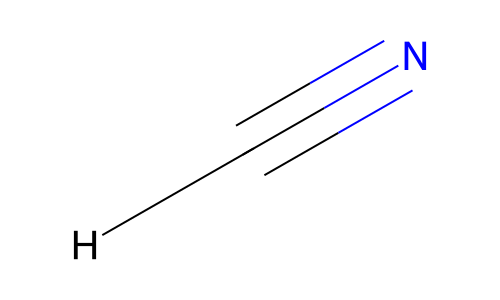

In [9]:
molecule_dict = {
    "name": "",
    "atoms": [
        {
            "atomic_number": 1,
            "formal_charge": 0,
            "is_aromatic": False,
            "stereochemistry": None,
            "name": "H",
        },
        {
            "atomic_number": 6,
            "formal_charge": 0,
            "is_aromatic": False,
            "stereochemistry": None,
            "name": "C",
        },
        {
            "atomic_number": 7,
            "formal_charge": 0,
            "is_aromatic": False,
            "stereochemistry": None,
            "name": "N",
        },
    ],
    "virtual_sites": [],
    "bonds": [
        {
            "atom1": 0,
            "atom2": 1,
            "bond_order": 1,
            "is_aromatic": False,
            "stereochemistry": None,
            "fractional_bond_order": None,
        },
        {
            "atom1": 1,
            "atom2": 2,
            "bond_order": 3,
            "is_aromatic": False,
            "stereochemistry": None,
            "fractional_bond_order": None,
        },
    ],
    "properties": {},
    "conformers": None,
    "partial_charges": None,
    "partial_charges_unit": None,
    "hierarchy_schemes": {},
}

from_dictionary = Molecule.from_dict(molecule_dict)

from_dictionary.visualize()

## From a file

We can construct a `Molecule` from a file or file-like object with the [`from_file()`](openff.toolkit.topology.Molecule.from_file) method. We're a bit constrained in what file formats we can accept, because they need to provide all the information needed to construct the molecular graph; not just coordinates, but also elements, formal charges, bond orders, and stereochemistry.

### From SDF file

We generally recommend the SDF format. The SDF file used here can be found [on GitHub](https://github.com/openforcefield/openff-toolkit/blob/main/docs/users/zw_l_alanine.sdf)

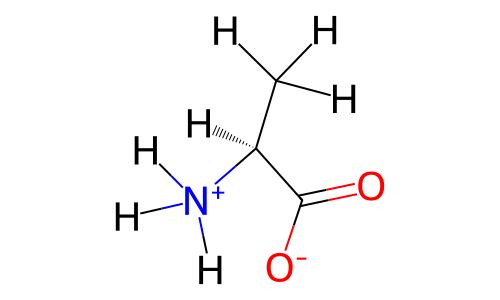

In [10]:
sdf_path = Molecule.from_file("zw_l_alanine.sdf")
assert zw_l_alanine.is_isomorphic_with(sdf_path)
sdf_path.visualize()

### From SDF file object

`from_file()` can also take a file object, rather than a path. Note that the object must be in binary mode!

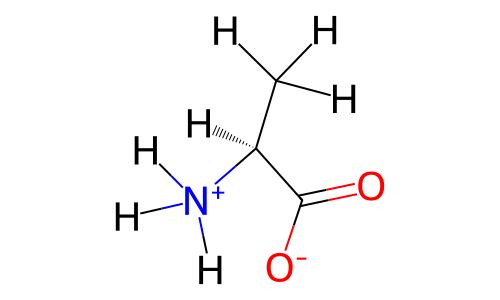

In [11]:
with open("zw_l_alanine.sdf", mode="rb") as file:
    sdf_object = Molecule.from_file(file, file_format="SDF")

assert zw_l_alanine.is_isomorphic_with(sdf_object)
sdf_object.visualize()

### From PDB file

The [`Topology.from_pdb()`] method is now the recommended method for loading all PDB files. It can interpret proteins, waters, ions, and small molecules from a PDB file as a Topology. It can infer the full chemical graph of the canonical amino acids (26 including protonation states) in capped and uncapped forms. It does this according to the [RCSB chemical component dictionary] --- the information is not explicitly in the input PDB file. The following block loads a PDB file containing a single protein.

[`Topology.from_pdb()`]: openff.toolkit.topology.Topology.from_pdb
[RCSB chemical component dictionary]: https://www.wwpdb.org/data/ccd

In [12]:
from openff.toolkit.utils import get_data_file_path

path = get_data_file_path("proteins/T4-protein.pdb")
topology = Topology.from_pdb(path)
protein = topology.molecule(0)
protein.visualize("nglview")

NGLWidget()

The following block loads a PDB containing two small molecules from PDB and SMILES.

In [13]:
top_from_pdb_from_smiles = Topology.from_pdb(
    get_data_file_path("molecules/po4_phenylphosphate.pdb"),
    unique_molecules=[
        Molecule.from_smiles("P(=O)([O-])([O-])([O-])"),
        Molecule.from_smiles("C1=CC=CC=C1OP(=O)([O-1])([O-1])"),
    ],
)

top_from_pdb_from_smiles.molecule(0).visualize("nglview")

NGLWidget()

In [14]:
top_from_pdb_from_smiles.molecule(1).visualize("nglview")

NGLWidget()

And for a maximalist example, the following block loads a single PDB file containing a protein, waters, ions, and a small molecule (the chemical identity of any small molecules must be provided with the `unique_molecules` keyword argument, and any small molecules' connectivity must have corresponding CONECT records in the PDB file).

In [15]:
from openff.toolkit.utils import get_data_file_path

ligand_path = get_data_file_path("molecules/PT2385.sdf")
ligand = Molecule.from_file(ligand_path)

complex_path = get_data_file_path("proteins/5tbm_complex_solv_box.pdb")
topology = Topology.from_pdb(complex_path, unique_molecules=[ligand])

molecule_smileses = [mol.to_smiles() for mol in topology.molecules]
counts = molecule_smileses
for smiles in sorted(set(molecule_smileses)):
    count = molecule_smileses.count(smiles)
    if len(smiles) > 1000:
        smiles = "protein"
    print(smiles, ":", count, "molecule(s)")

[Cl-] : 12 molecule(s)
[H]O[H] : 4413 molecule(s)
protein : 1 molecule(s)
[H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])C(C([C@@]2([H])O[H])(F)F)([H])[H])S(=O)(=O)C([H])([H])[H])[H] : 1 molecule(s)
[Na+] : 17 molecule(s)


## Other string identification formats

The OpenFF Toolkit supports a few text based molecular identity formats other than SMILES ([see above](#from-smiles))

### From InChI

The [`Molecule.from_inchi()`](openff.toolkit.topology.Molecule.from_inchi) method constructs a `Molecule` from an IUPAC [InChI](https://iupac.org/who-we-are/divisions/division-details/inchi/) string. Note that InChI cannot distinguish the zwitterionic form of alanine from the neutral form (see section 13.2 of the [InChI Technical FAQ](https://www.inchi-trust.org/technical-faq-2/)), so the toolkit defaults to the neutral form.

:::{warning}
The OpenFF Toolkit makes no guarantees about the atomic ordering produced by the `from_inchi` method. InChI is not intended to be an interchange format.
:::

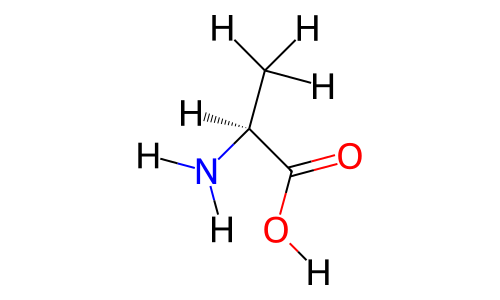

In [16]:
inchi = Molecule.from_inchi(
    "InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5,6)/t2-/m0/s1"
)

inchi.visualize()

### From IUPAC name

The [`Molecule.from_iupac()`](openff.toolkit.topology.Molecule.from_iupac) method constructs a `Molecule` from an IUPAC name.

:::{important}
This code requires the OpenEye toolkit.
:::

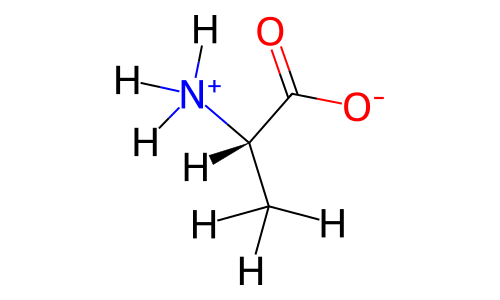

In [17]:
iupac = Molecule.from_iupac("(2S)-2-azaniumylpropanoate")

assert zw_l_alanine.is_isomorphic_with(iupac)

iupac.visualize()

## Re-ordering atoms in an existing `Molecule`

Most `Molecule` creation methods don't specify the ordering of atoms in the new `Molecule`. The [`Molecule.remap()`](openff.toolkit.topology.Molecule.remap) method allows a new ordering to be applied to an existing `Molecule`.

See also [](#mapped-smiles).

:::{warning}
The `Molecule.remap()` method is experimental and subject to change. 
:::

Before remapping: [H:3][C@@:2]([C:5](=[O:6])[O-:7])([C:1]([H:8])([H:9])[H:10])[N+:4]([H:11])([H:12])[H:13]
After remapping:  [H:3][C@@:2]([C:4](=[O:6])[O-:7])([C:1]([H:8])([H:9])[H:10])[N+:5]([H:11])([H:12])[H:13]


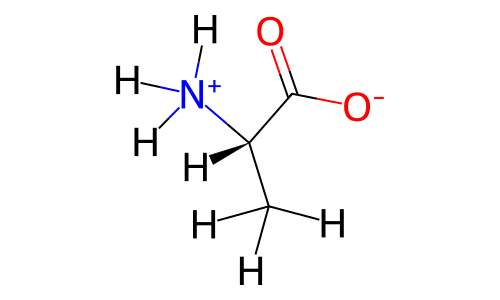

In [18]:
# Note that this mapping is off-by-one from the mapping taken
# by the remap method, as Python indexing is 0-based but SMILES
# is 1-based
print("Before remapping:", zw_l_alanine.to_smiles(mapped=True))

# Flip the order of the carbonyl carbon and oxygen
remapped = zw_l_alanine.remap(
    {
        0: 0,
        1: 1,
        2: 2,
        3: 4,  # Note these two mappings,
        4: 3,  # which are flipped!
        5: 5,
        6: 6,
        7: 7,
        8: 8,
        9: 9,
        10: 10,
        11: 11,
        12: 12,
    }
)

print("After remapping: ", remapped.to_smiles(mapped=True))

# Doesn't affect the identity of the molecule
assert zw_l_alanine.is_isomorphic_with(remapped)
remapped.visualize()

## Via `Topology` objects

The [`Topology`](openff.toolkit.topology.Topology) class represents a biomolecular system; it is analogous to the similarly named objects in GROMACS, MDTraj or OpenMM. Notably, it does not include co-ordinates and may represent multiple copies of a particular molecular species or even more complex mixtures of molecules. `Topology` objects are usually built up one species at a time from `Molecule` objects.

`Molecule` objects can be retrieved from a `Topology` via the [`Topology.molecule()`](openff.toolkit.topology.Topology.molecule) method by providing the index of the molecule within the topology. For a topology consisting of a single molecule, this is just `topology.molecule(0)`.

Constructor methods that are available for `Topology` but not `Molecule` generally require a `Molecule` to be provided via the `unique_molecules` keyword argument. The provided `Molecule` is used to provide the identity of the molecule, including aromaticity, bond orders, formal charges, and so forth. These methods therefore don't provide a route to the graph of the molecule, but can be useful for reordering atoms to match another software package.

### From an OpenMM `Topology`

The [`Topology.from_openmm()`](openff.toolkit.topology.Topology.from_openmm) method constructs an OpenFF `Topology` from an OpenMM [`Topology`](openmm.app.topology.Topology). The method requires that all the unique molecules in the `Topology` are provided as OpenFF `Molecule` objects, as the structure of an OpenMM `Topology` doesn't include the concept of a molecule. When using this method to create a `Molecule`, this limitation means that the method really only offers a pathway to reorder the atoms of a `Molecule` to match that of the OpenMM `Topology`.

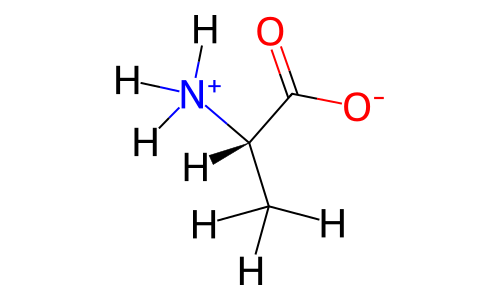

In [19]:
from openmm.app.pdbfile import PDBFile

openmm_topology = PDBFile("zw_l_alanine.pdb").getTopology()
openff_topology = Topology.from_openmm(openmm_topology, unique_molecules=[zw_l_alanine])

from_openmm_topology = openff_topology.molecule(0)

assert zw_l_alanine.is_isomorphic_with(from_openmm_topology)

from_openmm_topology.visualize()

### From an MDTraj `Topology`

The [`Topology.from_mdtraj()`](openff.toolkit.topology.Topology.from_mdtraj) method constructs an OpenFF `Topology` from an MDTraj [`Topology`](mdtraj.Topology). The method requires that all the unique molecules in the `Topology` are provided as OpenFF `Molecule` objects to ensure that the graph of the molecule is correct. When using this method to create a `Molecule`, this limitation means that the method really only offers a pathway to reorder the atoms of a `Molecule` to match that of the MDTraj `Topology`.

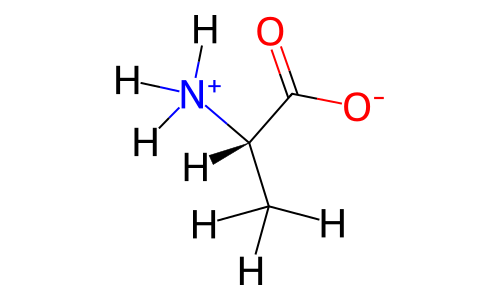

In [20]:
from mdtraj import load_pdb

mdtraj_topology = load_pdb("zw_l_alanine.pdb").topology
openff_topology = Topology.from_openmm(openmm_topology, unique_molecules=[zw_l_alanine])

from_mdtraj_topology = openff_topology.molecule(0)

assert zw_l_alanine.is_isomorphic_with(from_mdtraj_topology)

from_mdtraj_topology.visualize()

## From Toolkit objects

The OpenFF Toolkit calls out to other software to perform low-level tasks like reading SMILES or files. These external software packages are called toolkits, and presently include [RDKit](https://www.rdkit.org/) and the [OpenEye Toolkit](https://www.eyesopen.com/toolkit-development). OpenFF `Molecule` objects can be created from the equivalent objects in these toolkits.

### From RDKit `Mol`

The [`Molecule.from_rdkit()`](openff.toolkit.topology.Molecule.from_rdkit) method converts an [`rdkit.Chem.rdchem.Mol`](rdkit.Chem.rdchem.Mol) object to an OpenFF `Molecule`.

rdmol is of type <class 'rdkit.Chem.rdchem.Mol'>


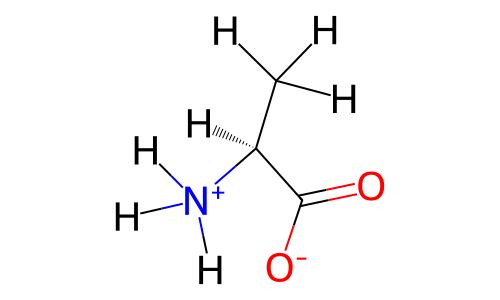

In [21]:
from rdkit import Chem

rdmol = Chem.MolFromSmiles("C[C@H]([NH3+])C([O-])=O")

print("rdmol is of type", type(rdmol))

from_rdmol = Molecule.from_rdkit(rdmol)

assert zw_l_alanine.is_isomorphic_with(from_rdmol)
from_rdmol.visualize()

### From OpenEye `OEMol`

The [`Molecule.from_openeye()`](openff.toolkit.topology.Molecule.from_rdkit) method converts an object that inherits from [`openeye.oechem.OEMolBase`](https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemClasses/OEMolBase.html) to an OpenFF `Molecule`.

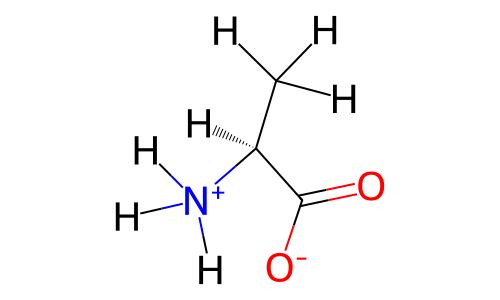

In [22]:
from openeye import oechem

oemol = oechem.OEGraphMol()
oechem.OESmilesToMol(oemol, "C[C@H]([NH3+])C([O-])=O")

assert isinstance(oemol, oechem.OEMolBase)

from_oemol = Molecule.from_openeye(oemol)

assert zw_l_alanine.is_isomorphic_with(from_oemol)
from_oemol.visualize()

## From QCArchive

[QCArchive](https://qcarchive.molssi.org/) is a repository of quantum chemical calculations on small molecules. The [`Molecule.from_qcschema()`](openff.toolkit.topology.Molecule.from_qcschema) method creates a `Molecule` from a record from the archive. Because the identity of a molecule can change of the course of a QC calculation, the Toolkit accepts records only if they contain a hydrogen-mapped SMILES code.

:::{note}
These examples use molecules other than l-Alanine because of their availability in QCArchive
:::

### From a QCArchive molecule record

The [`Molecule.from_qcschema()`](openff.toolkit.topology.Molecule.from_qcschema) method can take a molecule record queried from the QCArchive and create a `Molecule` from it.

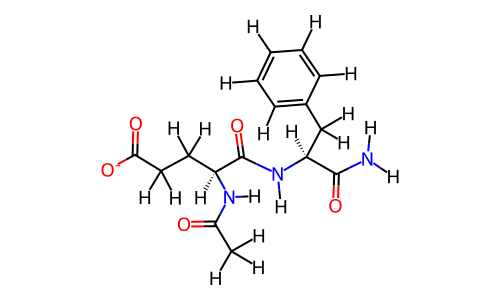

In [23]:
from qcportal import PortalClient

client = PortalClient("https://api.qcarchive.molssi.org:443/")

record = [*client.query_molecules(molecular_formula="C16H20N3O5")][-1]

from_qcarchive = Molecule.from_qcschema(record)

from_qcarchive.visualize()

### From a QCArchive optimisation record

`Molecule.from_qcschema()` can also take an optimisation record and create the corresponding `Molecule`.

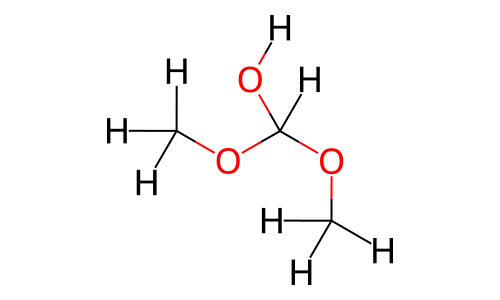

In [24]:
optimization_dataset = client.get_dataset(
    dataset_type="optimization",
    dataset_name="SMIRNOFF Coverage Set 1",
)
dimethoxymethanol_optimization = optimization_dataset.get_entry(
    "coc(o)oc-0",
)

from_optimisation = Molecule.from_qcschema(dimethoxymethanol_optimization)

from_optimisation.visualize()